In [14]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm
import scanpy as sc
import os

from huggingface_hub import hf_hub_download

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import joblib

from matplotlib import pyplot as plt
from scdataloader import utils as data_utils

from pyvis import network as pnx
import networkx as nx
import scipy.sparse
import gseapy as gp
from gseapy import dotplot

from scdataloader.utils import revert_to_raw

import scipy.sparse

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load gt

In [ ]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:657: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


In [ ]:
gwps = gwps.extract_links()

In [ ]:
# extracting PPI data from "computing the human interactome"
humaninter = pd.read_csv(
    "http://prodata.swmed.edu/humanPPI/bulk_download/GoodPairs.txt",
    sep="\t",
    skiprows=4,
)

In [ ]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of nodes: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)


Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842


## load data

In [3]:
ls ./normalize_log

 one2one_orthologs/            task4_human.h5ad   task8_frog.h5ad
 README                        task4_mouse.h5ad   task9-1_ant.h5ad
'Supplementary Table 3.xlsx'   task6_nema.h5ad    task9-1_mouse2_adult.h5ad
 task36_sea_urchin.h5ad        task6_sty.h5ad     task9_ant.h5ad
 task36_zebrafish.h5ad         task7_cat.h5ad     task9_mouse.h5ad
 task3_cat.h5ad                task7_dog.h5ad
 task3_tiger.h5ad              task8_fish.h5ad


In [3]:
human = sc.read("./normalize_log/task4_human.h5ad")
mouse = sc.read("./normalize_log/task4_mouse.h5ad")

In [4]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [5]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [6]:
commonset = set(mouse.var.index.str.upper()) & set(human.var.index)
len(commonset)

13090

In [7]:
human.obs.tissue.unique(), mouse.obs.tissue.unique()

(['Bladder', 'Heart', 'Kidney', 'Liver', 'Muscle']
 Categories (5, object): ['Bladder', 'Heart', 'Kidney', 'Liver', 'Muscle'],
 ['Bladder', 'Brain', 'Heart', 'Kidney', 'Liver', 'Muscle']
 Categories (6, object): ['Bladder', 'Brain', 'Heart', 'Kidney', 'Liver', 'Muscle'])

In [8]:
set(human.obs.celltype.unique().tolist()) & set(mouse.obs.celltype.unique().tolist())

{'B cell',
 'Basal cell',
 'Dendritic cell',
 'Endothelial cell',
 'Epithelial cell',
 'Erythroid cell',
 'Fibroblast',
 'Goblet cell',
 'Macrophage',
 'Mast cell',
 'Monocyte',
 'Neutrophil',
 'Smooth muscle cell',
 'T cell'}

In [9]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [10]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human_p = preprocessor(human.copy())
mouse_p = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4336 genes not known to the ontology
Removed 0 duplicate genes
Added 53976 genes in the ontology but not present in the dataset
starting QC
Seeing 5242 outliers (9.93% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70611
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism'

## generate results

In [11]:
model_checkpoint_file = "../../../w937u4o1.ckpt"  # w937u4o1.ckpt"


In [12]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert
FYI: scPrint is not attached to a `Trainer`.


In [ ]:
metrics = {}
clf_omni = None
shapes = []
for name in list(set(human.obs.celltype) & set(mouse.obs.celltype)):
    print(name)
    print("\nhuman")
    sub = human_p[human_p.obs.celltype == name].copy()
    print(sub.shape[0])
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=6000)
    topk = set(sub.var.index[sub.var.highly_variable])
    is_expr = set(
        human_p.var.index[
            np.array(human_p[human_p.obs.celltype == name].X.sum(0) > 0)[0]
        ]
    )
    in_mou = set(
        human_p.var.index[human_p.var.symbol.isin(mouse_p.var.symbol.str.upper())]
    )
    print(
        len(is_expr & set(model.genes) & topk),
        len(is_expr & set(model.genes) & topk & in_mou),
    )
    genes_h = list(is_expr & set(model.genes) & topk)

    grn_inferer = GNInfer(
        how="some",
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        genelist=genes_h,
        max_cells=1000,
        num_workers=4,
        batch_size=8,
        cell_type_col="celltype",
    )
    grn_h = grn_inferer(model, human_p[(human_p.X.sum(1) > 500)], cell_type=name)
    grn_h.var.index = make_index_unique(grn_h.var["symbol"].astype(str))

    print("\nmouse")
    sub = mouse_p[mouse_p.obs.celltype == name].copy()
    print(sub.shape[0])
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=6000)
    topk = set(sub.var.index[sub.var.highly_variable])
    is_expr = set(
        mouse_p.var.index[
            np.array(mouse_p[mouse_p.obs.celltype == name].X.sum(0) > 0)[0]
        ]
    )
    in_hum = set(
        mouse_p.var.index[mouse_p.var.symbol.str.upper().isin(human_p.var.symbol)]
    )
    print(
        len(is_expr & set(model.genes) & topk),
        len(is_expr & set(model.genes) & topk & in_hum),
    )
    genes_m = list(is_expr & set(model.genes) & topk)

    grn_inferer.genelist = genes_m
    grn_m = grn_inferer(model, mouse_p[(mouse_p.X.sum(1) > 500)], cell_type=name)
    grn_m.var.index = make_index_unique(grn_m.var["symbol"].astype(str))
    print("\n\n")
    break
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

B cell

human
171
3976 3780
not on wandb, could not set name


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 10419984, sparsity: 1.0

mouse
366
3973 3784
not on wandb, could not set name


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 12787776, sparsity: 1.0





# 1. Hub genes

We will use 2 different definition of centrality to compare the hubs of the networks in both states. The first one is the degree centrality, which is the number of connections of a node. The second one is the eigenvector centrality, which is the sum of the centrality of the neighbors of a node.

For each gene we mostly interogate their meaning with genecards, e.g. https://www.genecards.org/cgi-bin/carddisp.pl?gene=CD99

In [28]:
grn_m.var

,n_cells,uid,symbol,biotype,organism_id,branch_id,mt,ribo,hb,organism,ensembl_gene_id,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,TFs
symbol,,,,,,,,,,,,,,,,,,
Cdc45,211.0,2IgYexLtRNg8,CDC45,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000028,211,0.007117,0.007092,99.329605,224.0,5.416101,False
Apoh,395.0,u7T0dhlTR2C5,APOH,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000049,395,0.017570,0.017417,98.744996,553.0,6.317165,False
Cav2,3846.0,7R79lbqgSiIP,CAV2,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000058,3846,0.153142,0.142491,87.780390,4820.0,8.480737,False
Cox5a,11798.0,2swpuUNdoHDH,COX5A,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000088,11798,0.630679,0.488997,62.515092,19850.0,9.896009,False
Tfe3,635.0,4dTz1ex7k4Df,TFE3,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000134,635,0.020493,0.020286,97.982462,645.0,6.470799,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmem86b,133.0,5Vs385kNNmsq,TMEM86B,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000045282,133,0.004448,0.004438,99.577429,140.0,4.948760,False
Rtn4rl1,289.0,1Op6g6cDvqq7,RTN4RL1,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000045287,289,0.009436,0.009392,99.081782,297.0,5.697093,False
Insig1,1076.0,DZC7nUmZxDoR,INSIG1,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000045294,1076,0.036919,0.036254,96.581305,1162.0,7.058758,False


In [29]:
# between the two networks we have ~3000 genes in common over their 4000 genes
grn_m.var.index = grn_m.var.symbol.str.upper()
common = set(grn_h.var.symbol) & set(grn_m.var.symbol)
len(common)

963

In [21]:
# hub genes based on edge centrality (number of connections / strength of connections)
grn_h.grn.sum(0).sort_values(ascending=False).head(20)

symbol
SLC13A3     57.608017
JCHAIN      54.138416
RPL23       36.249783
FCER1G      32.930119
NDUFC2      30.553799
RGS2        28.689226
ACTB        27.616053
MT2A        25.835545
SEC61B      25.163452
SRGN        23.758196
EEF1A1      22.529945
CXCR4       21.974283
GZMB        21.201567
CUX2        20.559189
RPS6        20.128065
SERF2       19.364353
RPL21       19.121864
ZNF207      18.674433
EPB41L4B    17.557789
CST3        16.681494
dtype: float32

In [22]:
# without taking in account genes that are not present in the cancer network
grn_h.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(20)

symbol
NDUFC2      30.553799
RGS2        28.689226
ACTB        27.616053
EPB41L4B    17.557789
CST3        16.681494
RGS1        16.507284
CALM2       12.383200
ITM2C        9.411013
GZMA         8.854710
CD83         7.543646
RPLP1        7.423539
SLC4A3       7.383727
RPS27A       7.381475
UBC          7.278810
PPM1G        7.174497
NFKBIA       7.011289
NCOR1        6.486851
RPL10        6.433772
DEK          6.028742
PLAC8        5.910480
dtype: float32

In [30]:
# cancer hub genes
grn_m.grn.sum(0).sort_values(ascending=False).head(20)

symbol
ADORA3     71.822792
RPL4       48.884350
NDUFB2     44.258106
CD74       43.426994
RPLP1      34.328629
CD52       32.110344
PUM2       28.230053
SCUBE1     25.861454
LY6I       23.558325
RPAIN      22.213726
RPS24      21.883249
RPL18A     21.086426
PCLAF      20.776546
RPL37      20.070822
ACTB       20.061575
MS4A1      19.847042
CYP2C37    19.176422
RPL10      18.943897
TSPAN14    17.639355
DLGAP1     17.484068
dtype: float32

In [31]:
# without taking in account genes not present in the normal network
grn_m.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(20)

symbol
RPLP1       34.328629
RPS24       21.883249
ACTB        20.061575
MS4A1       19.847042
RPL10       18.943897
TSPAN14     17.639355
POU2AF1     13.067654
TMEM160     11.331847
SIN3B       11.042685
PUM1        10.594614
STMN1       10.026869
RPS19        9.092185
NCOR1        9.030873
IFITM3       7.831559
RPS27A       7.517421
MANF         7.440651
ITM2B        7.166789
TMEM176B     7.148547
PRDX1        7.112238
RPS2         6.727872
dtype: float32

In [ ]:
# top differential hubs
TOP = 10
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'RPLP1'}
{'ACTB', 'RGS2', 'NDUFC2'}


In [ ]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'MS4A1', 'RPLP1', 'RPS24', 'TSPAN14', 'RPL10'}
{'CST3', 'RGS2', 'NDUFC2', 'EPB41L4B'}


In [ ]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'PUM1', 'NCOR1', 'MS4A1', 'RPLP1', 'RPS19', 'RPL10', 'RPS24', 'POU2AF1', 'STMN1', 'TMEM160', 'TSPAN14', 'SIN3B'}
{'ITM2C', 'RGS2', 'CALM2', 'RGS1', 'NDUFC2', 'EPB41L4B', 'CST3', 'GZMA'}


overall we see that both are somewhat similar in the way the networks classifies main nodes but at least around half of the top 200 nodes are different between the two datasets and half of those are not due to diffent gene being used by the networks (50)

genes preferentially given as top elements in the tumor version only:

- CD99
- CPE
- DEFA1
- EIF4A1
- HLA-A
- HSPA1A
- LGALS1
- LUM
- PYDC2
- SERPING1
- SPOCK3
- THBS1

In [43]:
# we now compute eigen centrality creating a sparse network by only keeping the top 20 neighbors for each gene in the network
TOP = 20

grnutils.get_centrality(grn_h, TOP, top_k_to_disp=0)
grnutils.get_centrality(grn_m, TOP, top_k_to_disp=0)


Top central genes: []
Top central genes: []


[]

In [42]:
grn_h.var.centrality.sort_values(ascending=False).head(10)

symbol
FCER1G    0.276844
JCHAIN    0.276844
RPL23     0.276844
RPS6      0.269925
ACTB      0.264182
SRGN      0.263888
MT2A      0.249817
EEF1A1    0.244553
SERF2     0.240281
NDUFC2    0.217971
Name: centrality, dtype: float64

In [44]:
grn_m.var.centrality.sort_values(ascending=False).head(10)

symbol
RPLP1      0.268994
RPL4       0.268994
NDUFB2     0.264298
CD74       0.257679
RPL37      0.253856
RPL18A     0.251887
TSPAN14    0.242798
RPL10      0.240673
PCLAF      0.238238
ACTB       0.234860
Name: centrality, dtype: float64

In [ ]:
TOP = 10
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'RPLP1', 'TSPAN14', 'RPL10'}
{'NDUFC2'}


In [ ]:
scipy.stats.spearmanr(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(0).values)

SignificanceResult(statistic=np.float64(0.29967283792310595), pvalue=np.float64(4.3875743887677246e-75))

In [ ]:
np.corrcoef(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(0).values)[0, 1]

np.float64(0.5566375997092329)

In [ ]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'TSPAN14', 'SIN3B', 'RPS24'}
{'CST3', 'RGS2', 'NDUFC2'}


In [ ]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'IFITM3', 'TIMM13', 'NCOR1', 'MS4A1', 'RPS24', 'TMEM160', 'TSPAN14', 'SIN3B'}
{'NFKBIA', 'ITM2C', 'SNX9', 'RGS2', 'SNRPF', 'RGS1', 'NDUFC2', 'EPB41L4B', 'CST3', 'SMC2'}


# 2. Network similarity

We now look at the similarity of the two networks based on general overlap of their top K edges across their common nodes

In [66]:
K = 20
subgrn_h = grn_h.get(common).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(common).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K


np.float64(0.22923156801661473)

when looking at the top 20 connection for each genes in the network we see that on average only 50% of them agree between the two networks

# 3. Network communities

Again looking at the top 20 connections for each gene in the network we use the leiden (or louvain) algorithm to find communities in both networks. 

We then study the hub of these communities as well as their enrichment using enrichr and ontology databases. We will only look at communities between 20 and 200 genes


In [67]:
TOP = 20

grnutils.get_centrality(grn_h, TOP, top_k_to_disp=0)
grnutils.get_centrality(grn_m, TOP, top_k_to_disp=0)


Top central genes: []
Top central genes: []


[]

In [85]:
grn_h = grnutils.compute_cluster(grn_h, 1.0, max_comm_size=0)
grn_m = grnutils.compute_cluster(grn_m, 1.0, max_comm_size=0)

In [ ]:
# our communities
grn_h.var["cluster_1.0"].value_counts()  # .head(10)

cluster_1.0
0    1538
1     709
2     375
3     339
4     266
Name: count, dtype: int64

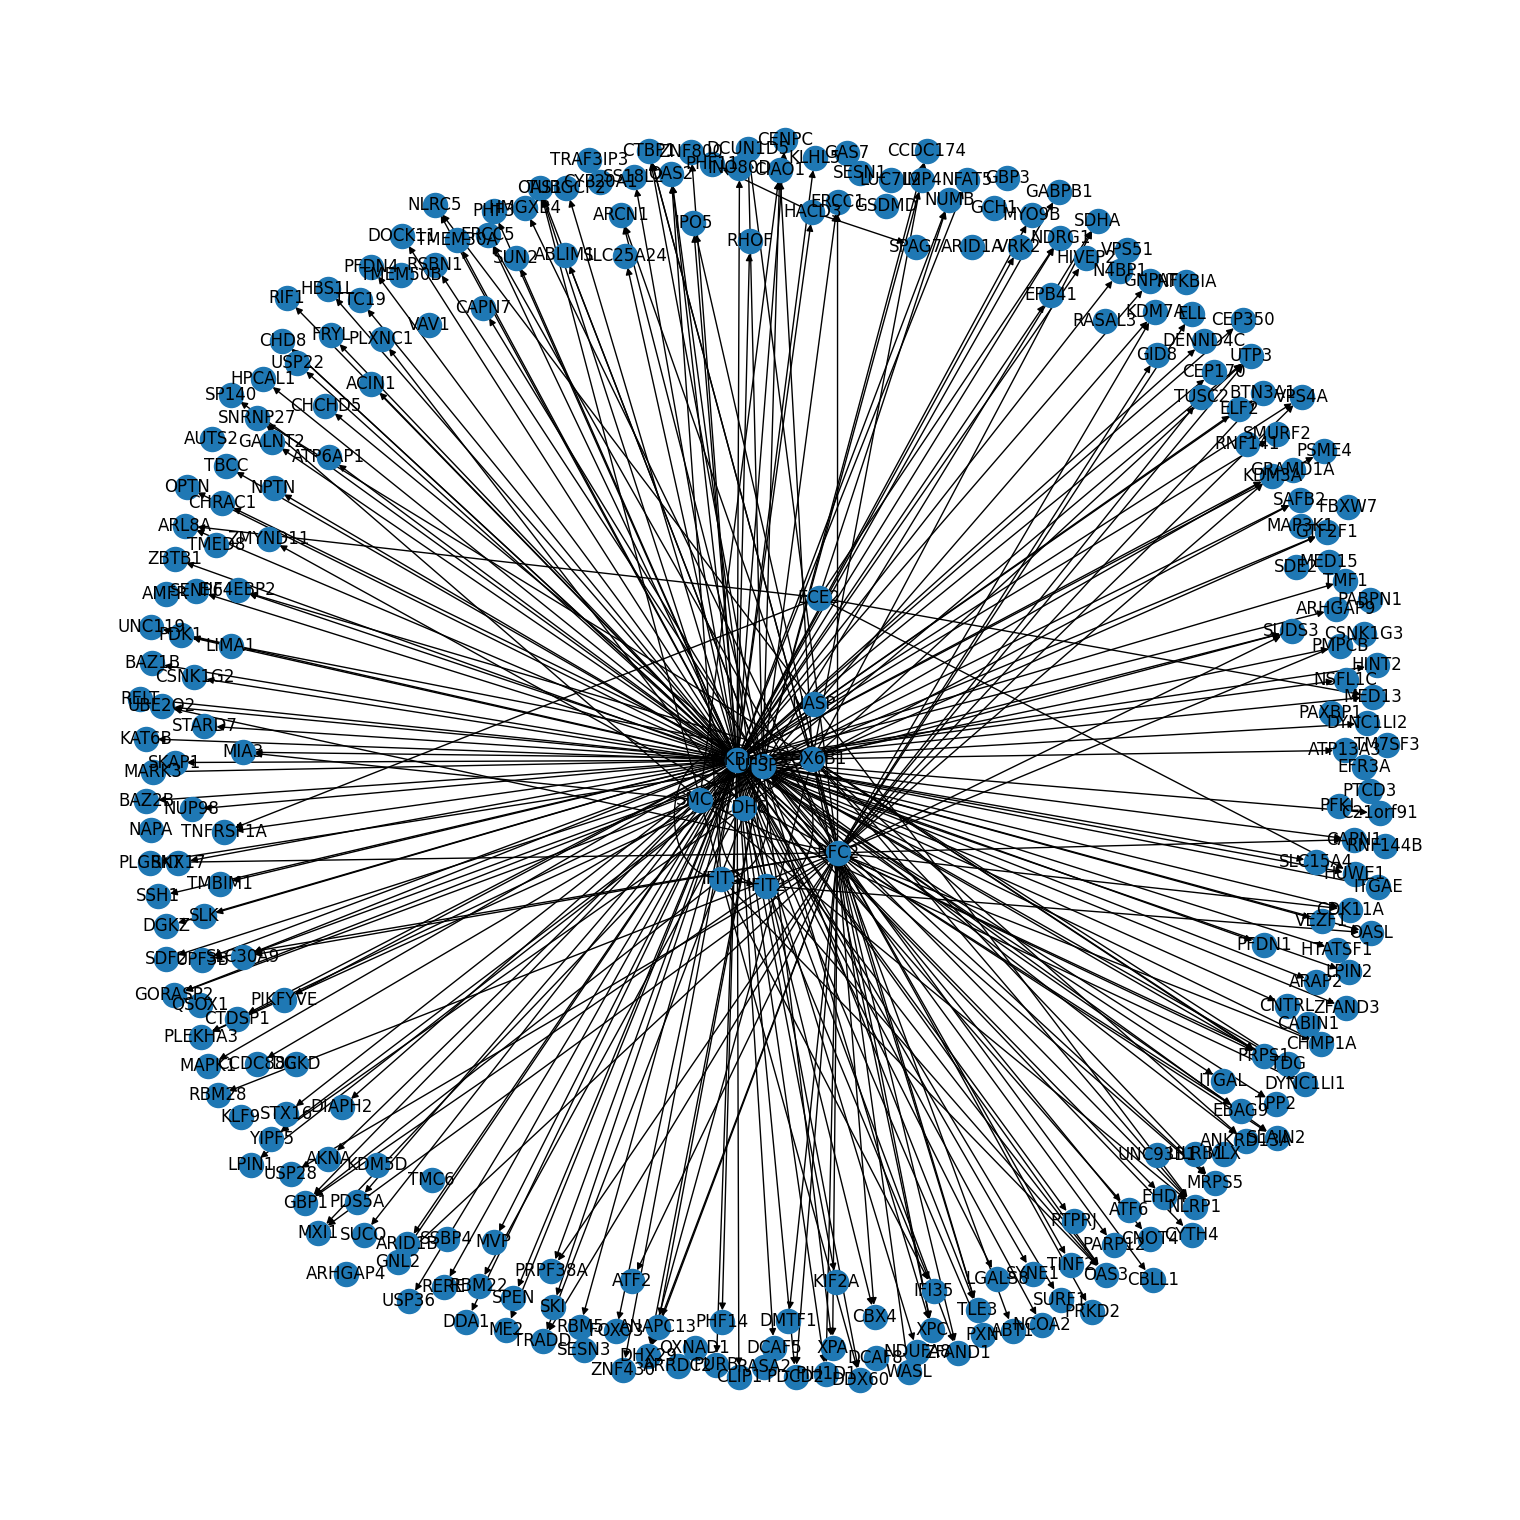

In [ ]:
G = grn_h.plot_subgraph(
    grn_h.var[grn_h.var["cluster_1.0"] == "4"].index.tolist(),
    only=300,
    interactive=False,
    
)  #


In [ ]:
# if you want to draw better looking networks
pnet = pnx.Network(notebook=True, cdn_resources="remote", directed=True)
pnet.from_nx(G)
# first_node = list(G.nodes)[-1]
# pnet.get_node(first_node)['color'] = "red"
pnet.save_graph("../figures/pyvis/grn_c_4.html")

In [114]:
"TP63" in grn_h.var.symbol.tolist()

False

In [ ]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=list(G.nodes),
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_h.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2022,OAS Antiviral Response R-HSA-8983711,0.000045,0.032645,0,0,inf,inf,OAS1;OAS2;OAS3;OASL


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


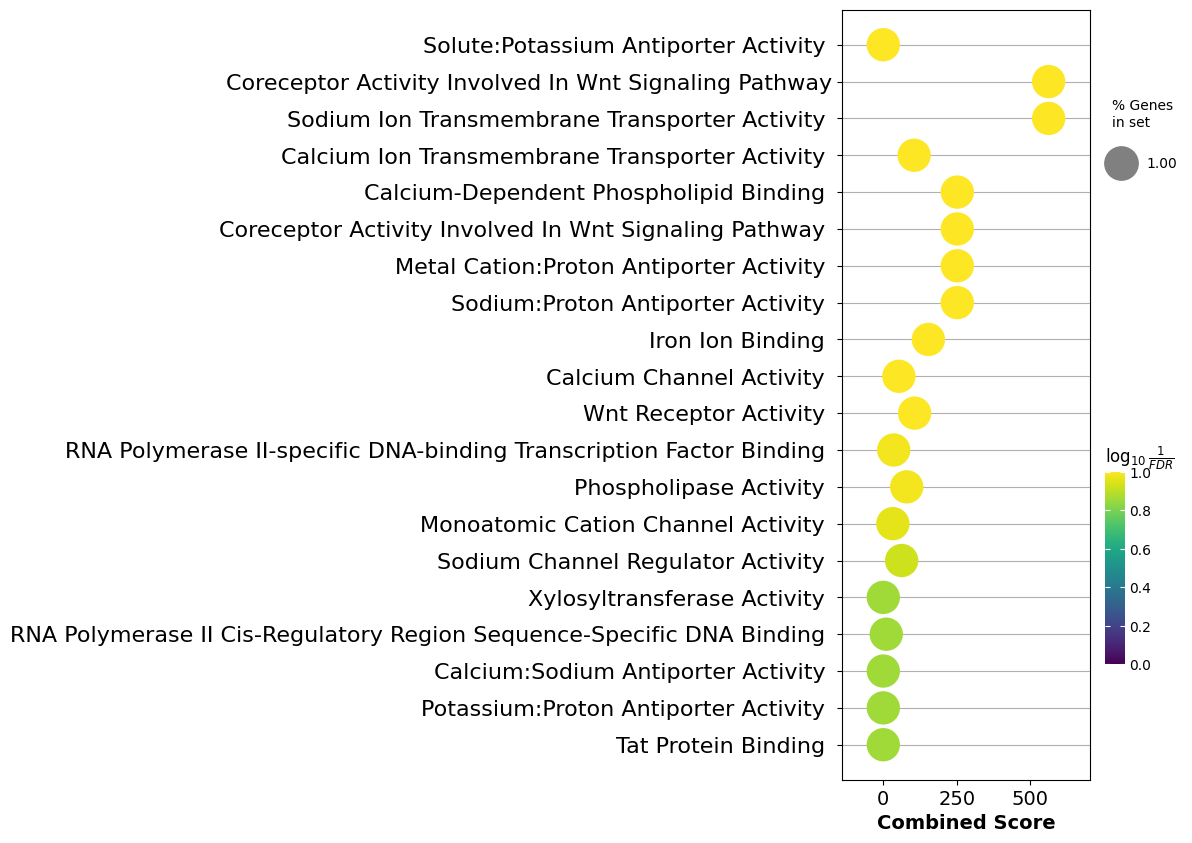

In [ ]:
# we make a plot of the enrichment
enr.res2d.Term = enr.res2d.Term.str.split("(").str[0].str.split(",").str[0]
ax = dotplot(
    enr.res2d.replace([np.inf, -np.inf], 0).dropna(),
    column="Adjusted P-value",
    # title='normal fibro PAGE4',
    cmap=plt.cm.viridis,
    size=4,  # adjust dot size
    top_term=20,
    figsize=(4, 10),
    cutoff=0.25,
)

['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4'] Index(['ABCF2', 'ITIH4', 'OLFM2', 'ICAM4', 'RIGI', 'KAZALD1', 'BST1', 'PANX1',
       'C9', 'FBXO2', 'ZNF410', 'ACVR1C', 'VAMP7', 'TOP2A', 'TAF4B',
       'KIAA1755', 'EDA', 'YPEL4', 'ENTPD3', 'GP9', 'NLGN2', 'CLCF1', 'RPRM',
       'ODF3B', 'MSC', 'NTF3', 'COL13A1', 'GP1BB', 'HSPA1A', 'TMEM158',
       'nan-82', 'NBPF19', 'SCO2', 'SMIM41'],
      dtype='object', name='symbol_2')


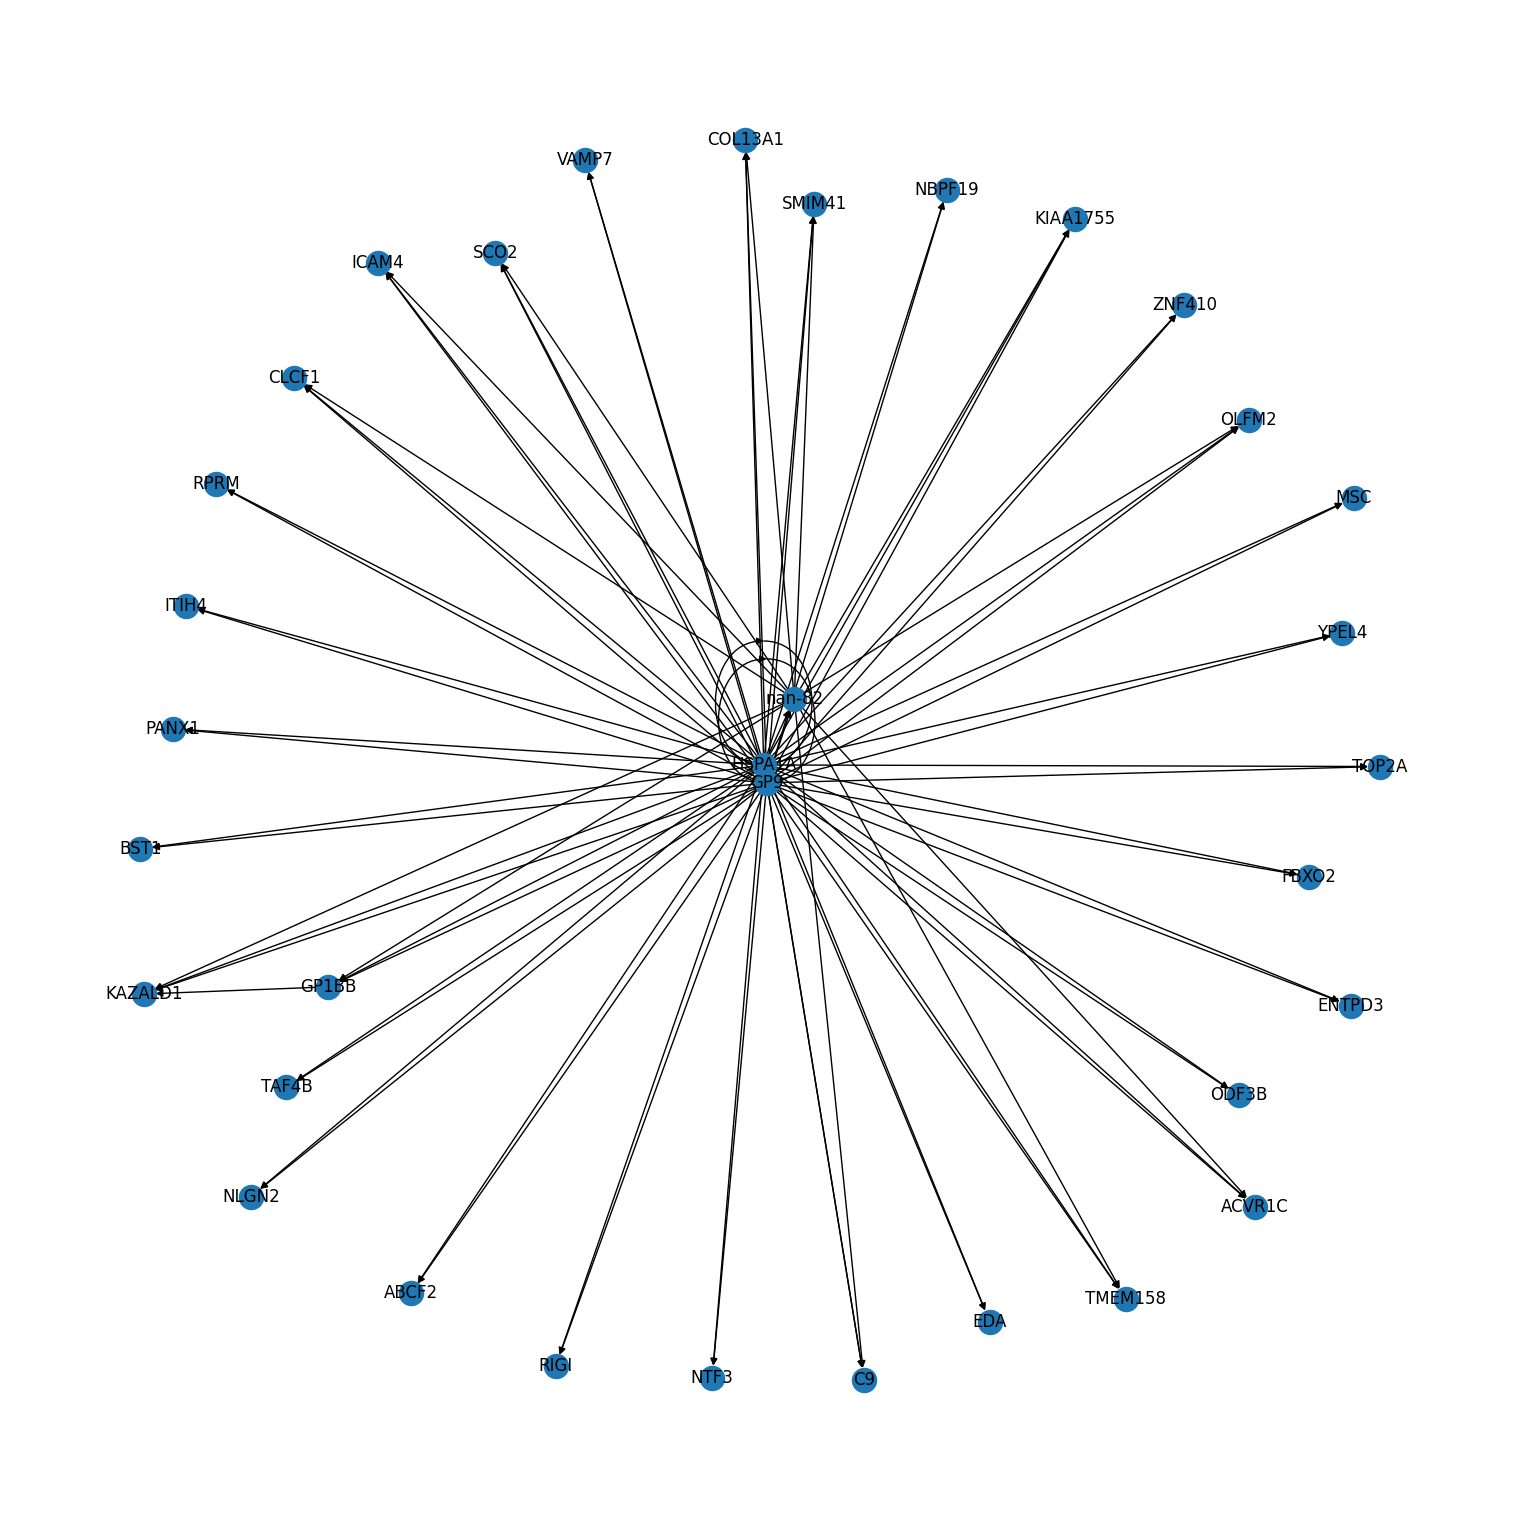

In [ ]:
G = grn_c.plot_subgraph(
    grn_c.var[grn_c.var["cluster_1.5"] == "5"].index.tolist(),
    only=80,
    interactive=False,
)  #


In [ ]:
pnet = pnx.Network(notebook=True, cdn_resources="remote", directed=True)
pnet.from_nx(G)
# first_node = list(G.nodes)[-1]
# pnet.get_node(first_node)['color'] = "red"
pnet.save_graph("../figures/pyvis/grn_c_5.html")

In [ ]:
grn_c.var.loc["nan-82"]  # par of the Glycoside Hydrolase Family

uid                    4giyQrh7tkXI
symbol                       nan-82
ncbi_gene_ids                      
biotype              protein_coding
description           novel protein
synonyms                           
organism_id                       2
public_source_id                9.0
created_by_id                     1
mt                            False
ribo                          False
hb                            False
organism             NCBITaxon:9606
TFs                           False
ensembl_id          ENSG00000269590
centrality                      0.0
cluster_1.5                       5
Name: nan-82, dtype: object